In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [71]:
fielding = pd.read_csv('Data/Lahman/Fielding.csv')
batting = pd.read_csv('Data/Lahman/Batting.csv')
pitching = pd.read_csv('Data/Lahman/Pitching.csv')
players = pd.read_csv('Data/Lahman/People.csv', encoding='latin1')
salaries = pd.read_csv('Data/Lahman/Salaries.csv')
survival_data = pd.read_csv('SurvivalData.csv')

pitching_cols = [
    'playerID', 'yearID', 'teamID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 
    'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'WP', 'BK', 'BFP', 'GF'
]

# Combine batting and fielding columns for position players
batting_cols = [
    'playerID', 'yearID', 'teamID', 'stint', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 
    'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP'
]
fielding_cols = [
    'playerID', 'yearID', 'teamID', 'stint', 'POS', 'G', 'GS', 'InnOuts', 'PO', 'A', 
    'E', 'DP', 'PB', 'WP', 'SB', 'CS', 'ZR'
]

pitching = pitching[pitching_cols]
batting = batting[batting_cols]
fielding = fielding[fielding_cols]
players = players[['playerID', 'birthYear']]

fielding = (
    fielding.groupby(['playerID', 'yearID', 'teamID', 'stint'])
    .agg('sum')
    .reset_index()
)

position_players = pd.merge(batting, fielding, on=['playerID', 'yearID', 'teamID'], how='outer')
position_players = pd.merge(position_players, salaries.drop('lgID',axis=1), on=['playerID', 'yearID', 'teamID'], how='left')
position_players = position_players.drop(columns=['PB', 'WP', 'SB_y', 'CS_y', 'ZR'])
position_players = position_players.merge(survival_data[['playerID', 'yearID', 'decline_event', 'time_to_event']],
                                               on=['playerID', 'yearID'], how='left')

pitchers = pd.merge(pitching, salaries, on=['playerID', 'yearID', 'teamID'], how='left')
pitchers = pitchers.merge(survival_data[['playerID', 'yearID', 'decline_event', 'time_to_event']],
                            on=['playerID', 'yearID'], how='left')

C:\Users\whawkins.RHIT-R90Y2R48\AppData\Local\Temp\ipykernel_5876\1936319541.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .agg('sum')


In [53]:
def prepare_salary_prediction_dataset(df):
    df = df.sort_values(['playerID', 'yearID'])
    
    # Create a list to store valid rows
    valid_rows = []
    
    # Group by player
    for _, player_group in df.groupby('playerID'):
        # Iterate through player's seasons
        for i in range(1, len(player_group)):
            # Previous season's stats
            prev_stats = player_group.iloc[i-1]
            # Current season's salary
            current_salary = player_group.iloc[i]['salary']
            
            # Create a row with previous year's stats and current year's salary
            row = prev_stats.copy()
            row['target_salary'] = current_salary
            valid_rows.append(row)
    
    # Convert to DataFrame
    prepared_df = pd.DataFrame(valid_rows)
    
    return prepared_df

In [54]:
# Prepare the dataset
position_players_f = position_players[(position_players['yearID'] >= 1985) & (position_players['yearID'] <= 2016)]
position_players_f = position_players_f.dropna(subset=['salary', 'decline_event'])

# Create dataset where each row is previous year's stats and current year's salary
salary_prediction_df = prepare_salary_prediction_dataset(position_players_f)

# Select features and target
X = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'salary', 'target_salary', 'stint_x', 'stint_y'])
y = salary_prediction_df['target_salary']

# Split and scale
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [55]:
# Model
param_grid = {
    'n_estimators': [20,40,80,160,320,500],
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                            param_grid=param_grid,
                            cv=5,
                            scoring='r2',
                            n_jobs=-1,
                            return_train_score=True)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))
print("Optimal number of trees:", grid_search.best_params_['n_estimators'])

Mean Squared Error: 12209717259633.773
R-squared: 0.41201022236066365
Optimal number of trees: 500


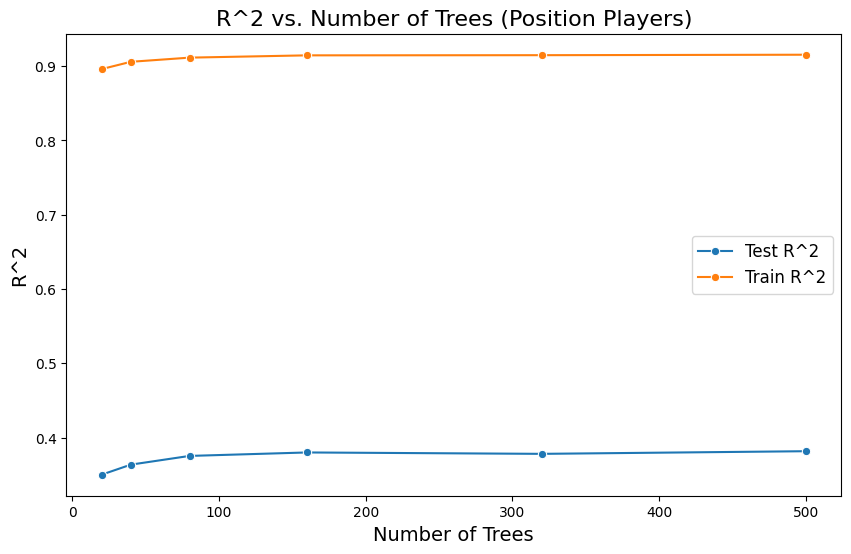

In [56]:
cv_results = grid_search.cv_results_
mean_test_r2 = cv_results['mean_test_score']
mean_train_r2 = cv_results['mean_train_score']
n_estimators = param_grid['n_estimators']

# Create a plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=n_estimators, y=mean_test_r2, label="Test R^2", marker='o')
sns.lineplot(x=n_estimators, y=mean_train_r2, label="Train R^2", marker='o')

plt.title("R^2 vs. Number of Trees (Position Players)", fontsize=16)
plt.xlabel("Number of Trees", fontsize=14)
plt.ylabel("R^2", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [57]:
X_original = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'salary', 'target_salary', 'stint_x', 'stint_y'])

# Feature set with new columns
X_with_new_features = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'salary', 'target_salary', 'stint_x', 'stint_y']).copy()
X_with_new_features['decline_event'] = salary_prediction_df['decline_event']
X_with_new_features['time_to_event'] = salary_prediction_df['time_to_event']

# Scale features
X_original_scaled = StandardScaler().fit_transform(X_original)
X_new_scaled = StandardScaler().fit_transform(X_with_new_features)

# Split data
X_orig_train, X_orig_test, y_train, y_test = train_test_split(X_original_scaled, y, test_size=0.2)
X_new_train, X_new_test, _, _ = train_test_split(X_new_scaled, y, test_size=0.2)

# Train models
model_original = RandomForestRegressor(n_estimators=160)
model_new = RandomForestRegressor(n_estimators=160)

model_original.fit(X_orig_train, y_train)
model_new.fit(X_new_train, y_train)

# Evaluate models
y_pred_original = model_original.predict(X_orig_test)
y_pred_new = model_new.predict(X_new_test)

print("Original Model Metrics:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_original))
print("R-squared:", r2_score(y_test, y_pred_original))

print("\nNew Model Metrics:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_new))
print("R-squared:", r2_score(y_test, y_pred_new))

# Feature importance for new model
feature_names = list(X_with_new_features.columns)
importances = model_new.feature_importances_
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for name, importance in feature_importance:
    print(f"{name}: {importance}")

Original Model Metrics:
Mean Squared Error: 10324533397837.762
R-squared: 0.3928088978028521

New Model Metrics:
Mean Squared Error: 18158780787687.68
R-squared: -0.06792720757158777

Feature Importances:
PO: 0.06129515526479405
BB: 0.0553739593291588
SO: 0.05405509833410059
A: 0.05074547968344885
RBI: 0.04761951484179526
G_x: 0.045755803472027165
R: 0.045349668813651094
AB: 0.042928634474297137
time_to_event: 0.04195008998745275
SB_x: 0.04179987490865173
H: 0.041336812378922935
G_y: 0.03984840296022848
GIDP: 0.03961667551834241
2B: 0.03897949476106683
DP: 0.03844280172929131
InnOuts: 0.03765558573618205
HR: 0.03671059007383099
E: 0.035478546766958934
IBB: 0.03513625073898387
HBP: 0.03164574413387362
SF: 0.030033385511697687
GS: 0.02922509152669515
3B: 0.027667126510886562
CS_x: 0.02709540265774108
SH: 0.020497276445125345
decline_event: 0.0037575334407954687


In [58]:
mean_test_r2

array([0.34998558, 0.36356864, 0.37529965, 0.37996   , 0.37808319,
       0.38164433])

In [59]:
mean_train_r2

array([0.8960382 , 0.90590994, 0.91151326, 0.91458926, 0.91481142,
       0.91543278])

In [61]:
.38164-.37996

0.0016799999999999593

In [73]:
# Prepare the dataset
pitchers_f = pitchers[(pitchers['yearID'] >= 1985) & (pitchers['yearID'] <= 2016)]
pitchers_f = pitchers_f.dropna(subset=['salary'])

# Create dataset where each row is previous year's stats and current year's salary
salary_prediction_df = prepare_salary_prediction_dataset(pitchers_f)

# Select features and target
X = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'lgID', 'salary', 'target_salary', 'stint'])
y = salary_prediction_df['target_salary']

# Split and scale
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model
param_grid = {
    'n_estimators': [20,40,80,160,320,500],
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                            param_grid=param_grid,
                            cv=5,
                            scoring='r2',
                            n_jobs=-1,
                            return_train_score=True)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))
print("Optimal number of trees:", grid_search.best_params_['n_estimators'])

Mean Squared Error: 7389645181718.149
R-squared: 0.3367712703885338
Optimal number of trees: 500


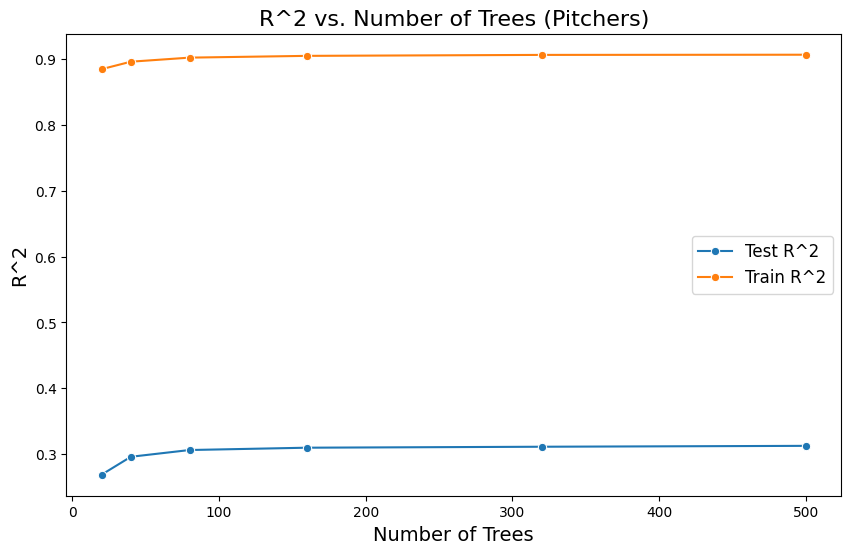

In [74]:
cv_results = grid_search.cv_results_
mean_test_r2 = cv_results['mean_test_score']
mean_train_r2 = cv_results['mean_train_score']
n_estimators = param_grid['n_estimators']

# Create a plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=n_estimators, y=mean_test_r2, label="Test R^2", marker='o')
sns.lineplot(x=n_estimators, y=mean_train_r2, label="Train R^2", marker='o')

plt.title("R^2 vs. Number of Trees (Pitchers)", fontsize=16)
plt.xlabel("Number of Trees", fontsize=14)
plt.ylabel("R^2", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [75]:
X_original = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'lgID', 'salary', 'target_salary', 'stint'])

# Feature set with new columns
X_with_new_features = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'lgID', 'salary', 'target_salary', 'stint']).copy()
X_with_new_features['decline_event'] = salary_prediction_df['decline_event']
X_with_new_features['time_to_event'] = salary_prediction_df['time_to_event']

# Scale features
X_original_scaled = StandardScaler().fit_transform(X_original)
X_new_scaled = StandardScaler().fit_transform(X_with_new_features)

# Split data
X_orig_train, X_orig_test, y_train, y_test = train_test_split(X_original_scaled, y, test_size=0.2)
X_new_train, X_new_test, _, _ = train_test_split(X_new_scaled, y, test_size=0.2)

# Train models
model_original = RandomForestRegressor(n_estimators=160)
model_new = RandomForestRegressor(n_estimators=160)

model_original.fit(X_orig_train, y_train)
model_new.fit(X_new_train, y_train)

# Evaluate models
y_pred_original = model_original.predict(X_orig_test)
y_pred_new = model_new.predict(X_new_test)

print("Original Model Metrics:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_original))
print("R-squared:", r2_score(y_test, y_pred_original))

print("\nNew Model Metrics:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_new))
print("R-squared:", r2_score(y_test, y_pred_new))

# Feature importance for new model
feature_names = list(X_with_new_features.columns)
importances = model_new.feature_importances_
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for name, importance in feature_importance:
    print(f"{name}: {importance}")

Original Model Metrics:
Mean Squared Error: 8556228344444.647
R-squared: 0.24805560530694448

New Model Metrics:
Mean Squared Error: 12059126722790.738
R-squared: -0.05978853988664645

Feature Importances:
ERA: 0.09012972985893983
SO: 0.0882946239781197
BAOpp: 0.08540181176033221
BB: 0.08045305774089098
G: 0.07083965812978657
H: 0.064034002496098
HR: 0.06379128192760988
BFP: 0.05987582117012805
IPouts: 0.05827343807815392
WP: 0.051878806471176375
ER: 0.05182776419222991
L: 0.04879368324337639
W: 0.04492519404851019
GF: 0.04271719449178198
SV: 0.02420216489699115
BK: 0.02337540850744998
GS: 0.023201973046314557
CG: 0.018572603143781508
SHO: 0.00911999347988212
time_to_event: 0.000244804331931148
decline_event: 4.69850065155855e-05


In [66]:
mean_train_r2

array([0.88469094, 0.89617007, 0.9020187 , 0.90436865, 0.90586491,
       0.90618521])

In [67]:
mean_test_r2

array([0.27020695, 0.29439603, 0.30561781, 0.30891856, 0.3102134 ,
       0.3121551 ])

In [68]:
.9062-.90436

0.0018399999999999528

In [69]:
.312155-.3089186

0.003236400000000028